# HVAC vs Temperature
Steve Smith
Dec 2024
* The goal of this is to predict HVAC usage for a given outdoor temp. 
* This could help determine how much more money is spent for a given temp difference or if there are inefficiences in HVAC. 

There are two sources for this data to combine: 
1. Historical outdoor temperatures for the past year
2. Historical heating and cooling system usage provided by NEST
Need to add a document on how this was obtainied

## Load modules and data

In [6]:
import pandas as pd
from plotnine import ggplot,aes,geom_point,geom_line,geom_abline,ylab,xlab
from sklearn.linear_model import LinearRegression
import numpy as np

In [28]:
date_format="%Y-%m-%d"
DATA_DIR="~/Documents/"
WEATHER_DATA= f"{DATA_DIR}weather.tsv" 
HVAC_USAGE= f"{DATA_DIR}energy_use.tsv" 

# Data from National Weather 
weather=pd.read_csv(WEATHER_DATA,sep="\t")
weather_long=pd.melt(weather,id_vars=["Unnamed: 0","STATION","DATE"])
# convert to date format
weather_long['DATE']=pd.to_datetime(weather_long['DATE'],format=date_format)
display(weather_long)

# Data from NEST
energy_use=pd.read_csv(HVAC_USAGE,sep="\t")
energy_use['use_mins']=energy_use['data']/60
energy_use['asDATE']=pd.to_datetime(energy_use['start'],format="ISO8601")
energy_use['DATE']=pd.to_datetime(energy_use['asDATE']).dt.strftime(date_format)
energy_use['asDATE']=pd.to_datetime(energy_use['asDATE'],format=date_format)

display(energy_use)

,Unnamed: 0,STATION,DATE,variable,value
0,41494,USW00013739,2023-01-01,TAVG,51.0
1,41495,USW00013739,2023-01-02,TAVG,46.0
2,41496,USW00013739,2023-01-03,TAVG,52.0
3,41497,USW00013739,2023-01-04,TAVG,59.0
4,41498,USW00013739,2023-01-05,TAVG,58.0
...,...,...,...,...,...
1707,41917,USW00013739,2024-02-28,TOBS,NaN
1708,41918,USW00013739,2024-02-29,TOBS,NaN
1709,41919,USW00013739,2024-03-01,TOBS,NaN
1710,41920,USW00013739,2024-03-02,TOBS,NaN


,Unnamed: 0,start,stop,type,data,use_mins,asDATE,DATE
0,0,2023-04-09T04:00:00Z,2023-04-10T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_COOLING,0,0.0,2023-04-09 04:00:00+00:00,2023-04-09
1,0,2023-04-09T04:00:00Z,2023-04-10T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,21360,356.0,2023-04-09 04:00:00+00:00,2023-04-09
2,0,2023-04-09T04:00:00Z,2023-04-10T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_LEAF,29400,490.0,2023-04-09 04:00:00+00:00,2023-04-09
3,0,2023-04-10T04:00:00Z,2023-04-11T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_COOLING,180,3.0,2023-04-10 04:00:00+00:00,2023-04-10
4,0,2023-04-10T04:00:00Z,2023-04-11T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,19500,325.0,2023-04-10 04:00:00+00:00,2023-04-10
...,...,...,...,...,...,...,...,...
958,0,2024-03-04T05:00:00Z,2024-03-05T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,8430,140.5,2024-03-04 05:00:00+00:00,2024-03-04
959,0,2024-03-04T05:00:00Z,2024-03-05T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_LEAF,22980,383.0,2024-03-04 05:00:00+00:00,2024-03-04
960,0,2024-03-05T05:00:00Z,2024-03-06T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_COOLING,0,0.0,2024-03-05 05:00:00+00:00,2024-03-05
961,0,2024-03-05T05:00:00Z,2024-03-06T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,14340,239.0,2024-03-05 05:00:00+00:00,2024-03-05


## Plots
### Outdoor temp vs date
* Weather data includes avg temp, max and min for the weather station in F
* As ecpected the temp is max in summer and min in winter; there are also intra-day fluxuations
* For HVAC data, will use TAVG as the representative temp for the day

/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 431 rows containing missing values.
/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 428 rows containing missing values.


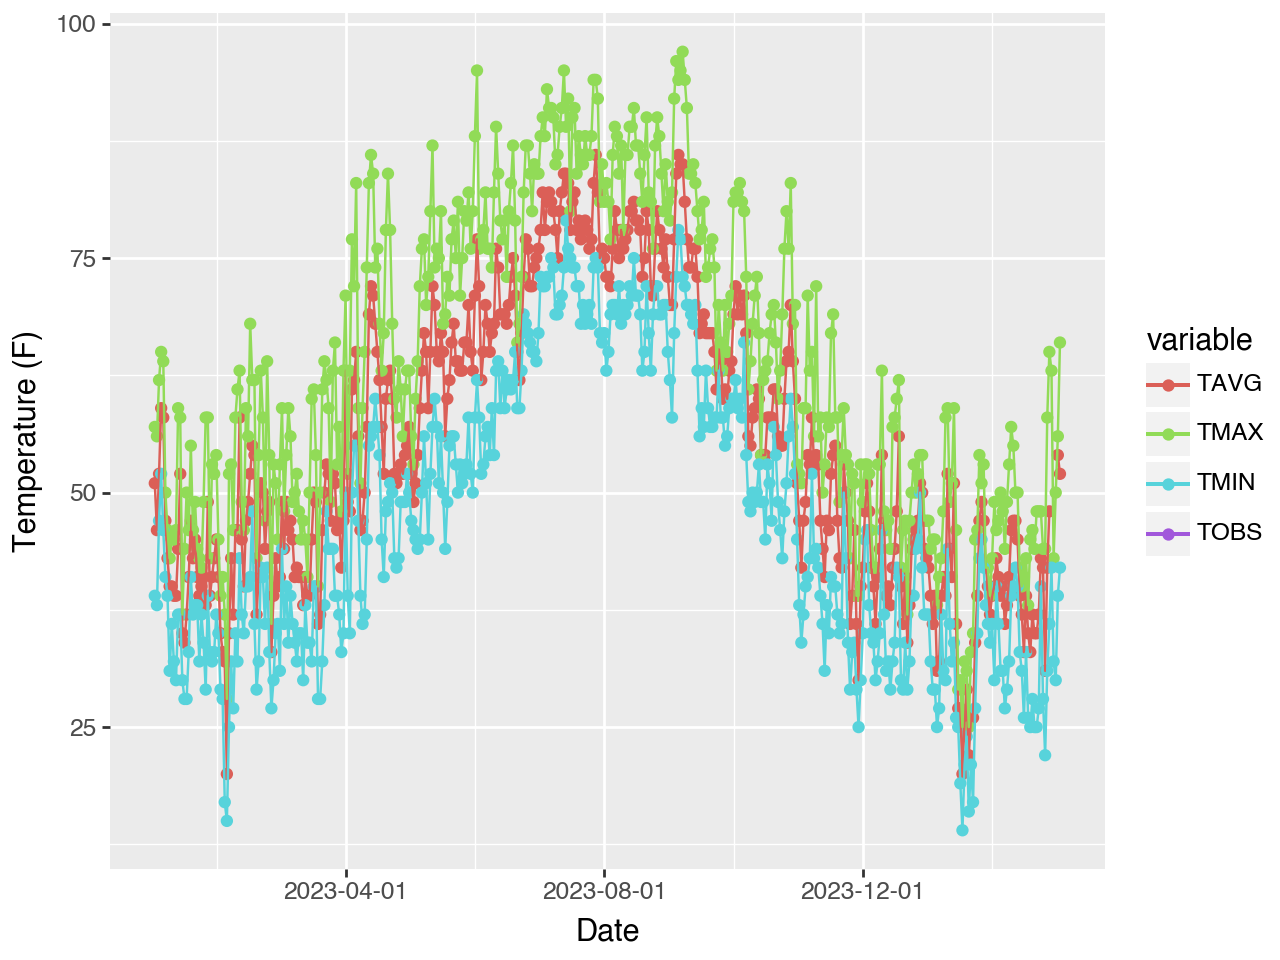

In [23]:

(ggplot(weather_long,aes("DATE","value",color="variable"))+
 geom_point()+
 geom_line()+
 ylab("Temperature (F)")+
 xlab("Date"))


### HVAC usage from year
* Data as reported from NEST for heat, cool and leaf
* General correlation of heating in winter, cooling in summer with other non correlative points
* NEST also has "leaf" which is not all that useful
* My HVAC system has multiple fuel types and modes which are not captured here (just heat or cool)

In [29]:
type(energy_use['DATE'][0])

str

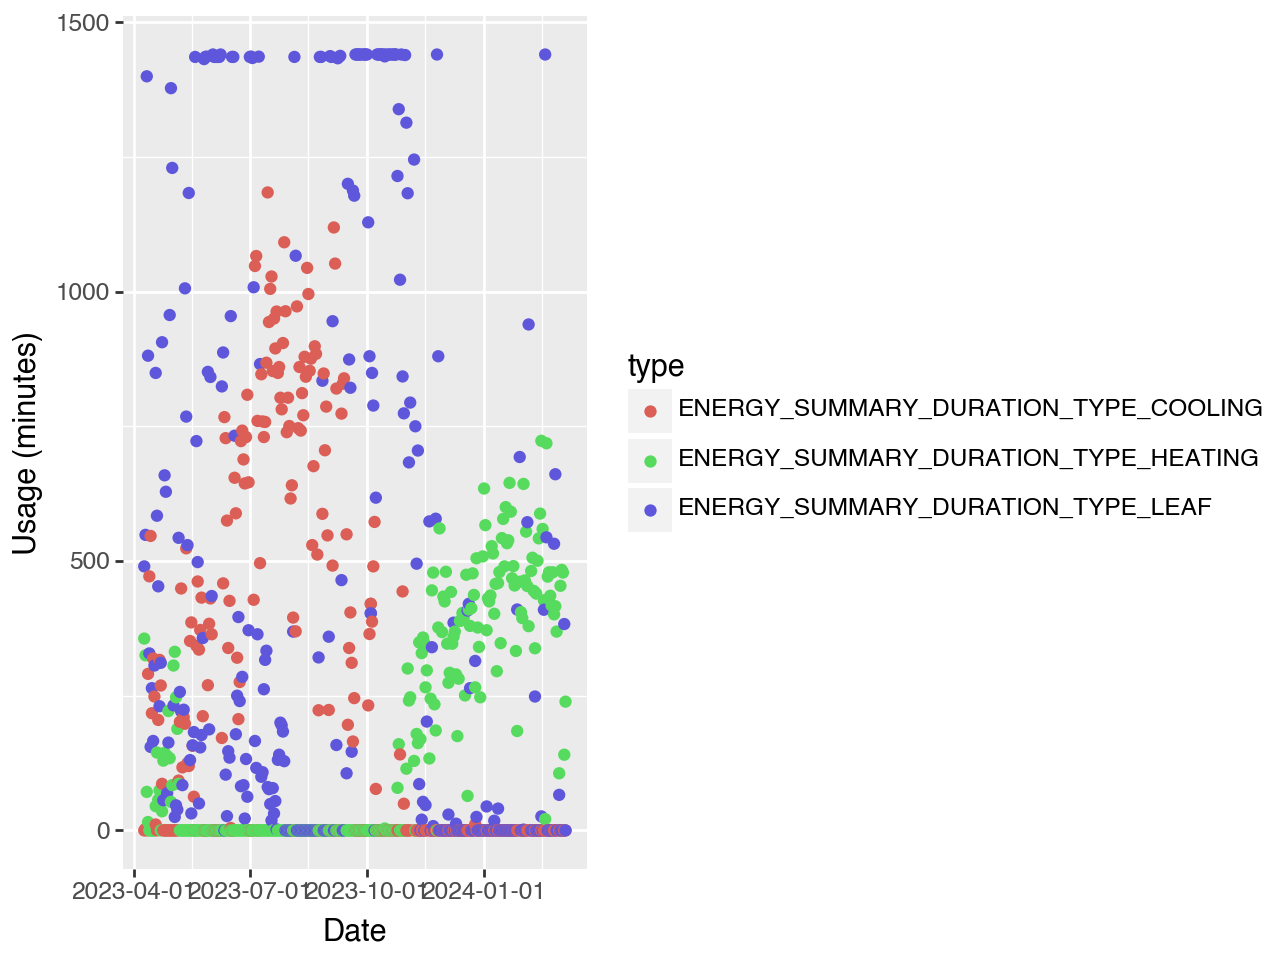

In [30]:
(ggplot(energy_use,aes("asDATE","use_mins",color="type"))+
 geom_point()+
 ylab("Usage (minutes)")+
 xlab("Date"))


### Join HVAC usage and avg daily temp
* Join the HVAC data with the avg daily temp based on date
* HVAC was not used every day

In [31]:
energy_weather=pd.merge(weather,energy_use,on="DATE")
energy_weather


,Unnamed: 0_x,STATION,DATE,TAVG,TMAX,TMIN,TOBS,Unnamed: 0_y,start,stop,type,data,use_mins,asDATE
0,41592,USW00013739,2023-04-09,47.0,59.0,36.0,NaN,0,2023-04-09T04:00:00Z,2023-04-10T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_COOLING,0,0.0,2023-04-09 04:00:00+00:00
1,41592,USW00013739,2023-04-09,47.0,59.0,36.0,NaN,0,2023-04-09T04:00:00Z,2023-04-10T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,21360,356.0,2023-04-09 04:00:00+00:00
2,41592,USW00013739,2023-04-09,47.0,59.0,36.0,NaN,0,2023-04-09T04:00:00Z,2023-04-10T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_LEAF,29400,490.0,2023-04-09 04:00:00+00:00
3,41593,USW00013739,2023-04-10,50.0,65.0,37.0,NaN,0,2023-04-10T04:00:00Z,2023-04-11T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_COOLING,180,3.0,2023-04-10 04:00:00+00:00
4,41593,USW00013739,2023-04-10,50.0,65.0,37.0,NaN,0,2023-04-10T04:00:00Z,2023-04-11T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,19500,325.0,2023-04-10 04:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
952,41920,USW00013739,2024-03-02,54.0,56.0,39.0,NaN,0,2024-03-02T05:00:00Z,2024-03-03T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,29010,483.5,2024-03-02 05:00:00+00:00
953,41920,USW00013739,2024-03-02,54.0,56.0,39.0,NaN,0,2024-03-02T05:00:00Z,2024-03-03T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_LEAF,0,0.0,2024-03-02 05:00:00+00:00
954,41921,USW00013739,2024-03-03,52.0,66.0,42.0,NaN,0,2024-03-03T05:00:00Z,2024-03-04T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_COOLING,0,0.0,2024-03-03 05:00:00+00:00
955,41921,USW00013739,2024-03-03,52.0,66.0,42.0,NaN,0,2024-03-03T05:00:00Z,2024-03-04T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,28710,478.5,2024-03-03 05:00:00+00:00


### Linear model of HVAC vs temp


In [61]:

def comptue_lm(df_in):
    usage_model = LinearRegression()
    usage_model.fit(np.array(df_in['TAVG']).reshape(-1, 1), np.array(df_in['use_mins']))
    # Lm fits
    lm_results={'slope':usage_model.coef_[0],'yint':usage_model.intercept_,'fit_model':usage_model}
    print(f"Fitted Usage equation: {lm_results['slope']} x Tavg + {lm_results['yint']}")

    return lm_results

lm_in_cool=energy_weather[(energy_weather['type']=="ENERGY_SUMMARY_DURATION_TYPE_COOLING") & (energy_weather['use_mins']>0)]
lm_in_heat=energy_weather[(~energy_weather['TAVG'].isna()) &(energy_weather['type']=="ENERGY_SUMMARY_DURATION_TYPE_HEATING") & (energy_weather['use_mins']>0)]

lm_res_cool=comptue_lm(lm_in_cool)
lm_res_heat=comptue_lm(lm_in_heat)




Fitted Usage equation: 34.053364170105894 x Tavg + -1895.4648937205343
Fitted Usage equation: -12.303180928162043 x Tavg + 898.1996421696108


/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 6 rows containing missing values.


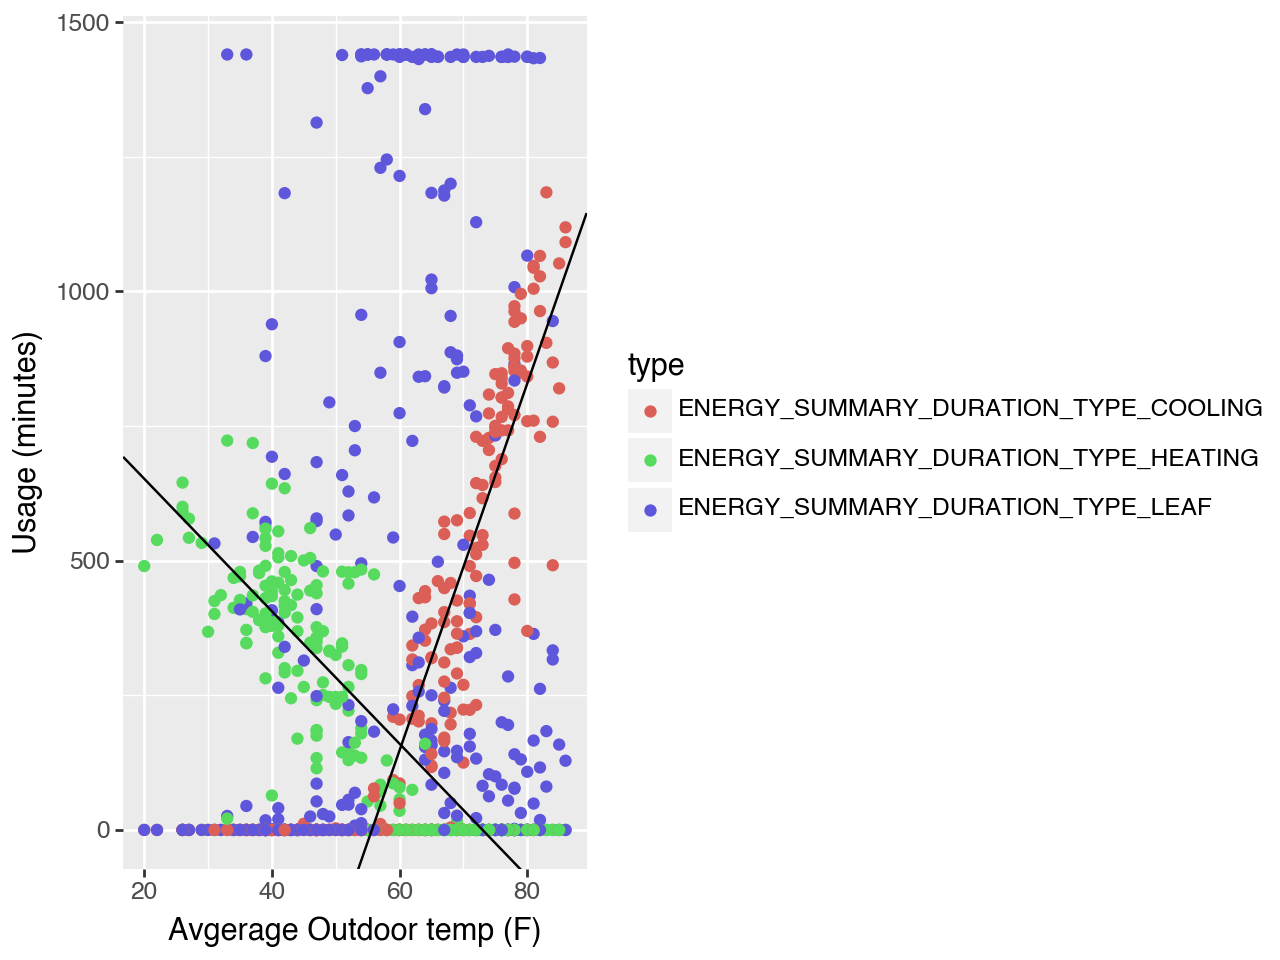

In [59]:
(ggplot(energy_weather,aes("TAVG","use_mins",color="type"))+geom_point()+
  geom_abline(slope=lm_res_cool['slope'],intercept = lm_res_cool['yint'])+
  geom_abline(slope=lm_res_heat['slope'],intercept = lm_res_heat['yint'])+
  ylab("Usage (minutes)")+
  xlab("Avgerage Outdoor temp (F)"))

## Predictions
* From the lm models above, I can predict how much heat or cool usage for a given outside temp


In [72]:

# How many hours does heat run on a 30, 40 & 50 degree day?
display(lm_res_heat['fit_model'].predict(np.array([30,40,50]).reshape(-1,1))/60)

# How many hours does A/C run on a 70,80,90 degree day?
display(lm_res_cool['fit_model'].predict(np.array([70,80,90]).reshape(-1,1))/60)




array([8.81840357, 6.76787342, 4.71734326])

array([ 8.1378433 , 13.813404  , 19.48896469])

# Takeaways & Future
* Cooling usage is more than double that of heating usage for a given temp difference (12 mins/degree vs 34 mins/degree for cooling)
* Is there a way to differentiate between heat/cool stages and heat fuel sources? 
* Is there more granular temp data (hourly)?
* Is there a way to add the set point of the thermostat-> this way could ask the question what changing the thermostat has
* Add in pricing info to translate usage into cost
* Add automatically downloading NEST and/or weather data
* Add README on how to obtain NEST and weather data  
* Clean up plots